In [1]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPClassifier


In [11]:
data = pd.read_csv("../../data/new_features.csv")
delete_feature = ['Unnamed: 0','个人编码']
data = data.drop(delete_feature,axis=1)

In [7]:
# 加载rf模型和特征列表
loaded_data_rf = joblib.load("../../model_development/models/rf_model/RF_19_0.92255.pkl")
rf_model = loaded_data_rf['model']
rf_features = loaded_data_rf['features']

rf_selected_features = data[rf_features]
rf_selected_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ALL_SUM                16000 non-null  float64
 1   治疗费用在总金额占比             16000 non-null  float64
 2   交易时间_NN                16000 non-null  int64  
 3   交易时间_NN_and_就诊的月数      16000 non-null  int64  
 4   药品费发生金额_SUM_波动         16000 non-null  float64
 5   中成药费发生金额_SUM_波动        16000 non-null  float64
 6   基本统筹基金支付金额_SUM_波动      16000 non-null  float64
 7   月就诊天数差                 16000 non-null  float64
 8   月统筹金额差                 16000 non-null  float64
 9   月药品金额差                 16000 non-null  float64
 10  医院_药品_AVG_调整           16000 non-null  float64
 11  个人账户金额_SUM_调整          16000 non-null  float64
 12  中草药费发生金额_SUM_病种费用标准差值  15997 non-null  float64
 13  月就诊次数_MAX_医院费用标准差值     16000 non-null  float64
 14  月统筹金额_MAX_医院费用标准差值     16000 non-null  float64
 15  月就

In [8]:
# 加载lgb模型和特征列表
loaded_data_lgb = joblib.load("../../model_development/models/lgb_model\lgbm_12_0.92814.pkl")
lgb_model = loaded_data_lgb['model']
lgb_features = loaded_data_lgb['features']

lgb_selected_features = data[lgb_features]
lgb_selected_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   月药品金额_MAX              16000 non-null  float64
 1   顺序号_NN                 16000 non-null  int64  
 2   本次审批金额_SUM             16000 non-null  float64
 3   交易时间_NN                16000 non-null  int64  
 4   治疗费发生金额_SUM_波动         16000 non-null  float64
 5   非账户支付金额_SUM_波动         16000 non-null  float64
 6   月统筹金额差                 16000 non-null  float64
 7   医院_统筹金_MAX_病种费用标准差值    15997 non-null  float64
 8   医用材料发生金额_SUM_病种费用标准差值  15997 non-null  float64
 9   月就诊天数_AVG_病种平均费用差      16000 non-null  float64
 10  医院_就诊天数_AVG_病种平均费用差    16000 non-null  float64
 11  中成药费发生金额_SUM_病种平均费用差   16000 non-null  float64
dtypes: float64(10), int64(2)
memory usage: 1.5 MB


In [9]:
# 分离特征和目标变量
X = data.drop(['RES'], axis=1)
y = data['RES']

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 根据特征列表选择数据
X_test_rf = X_test[rf_features]
X_test_lgb = X_test[lgb_features]


# 原始模型性能

In [10]:
# 进行预测
rf_predictions = rf_model.predict_proba(X_test_rf)[:, 1]
lgb_predictions = lgb_model.predict_proba(X_test_lgb)[:, 1]

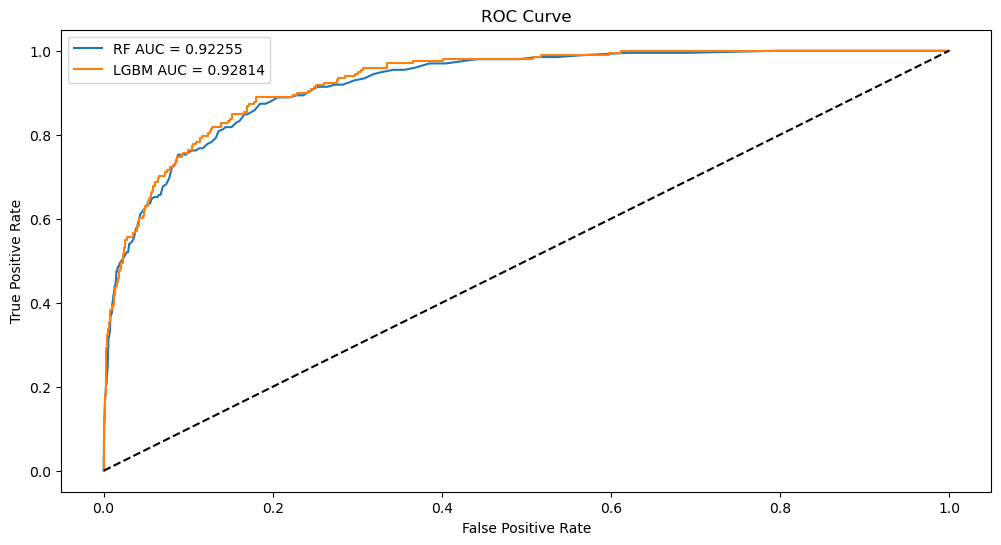

In [11]:
# 绘制 ROC-AUC 曲线
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_predictions)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, lgb_predictions)
auc_rf = auc(fpr_rf, tpr_rf)
auc_lgb = auc(fpr_lgb, tpr_lgb)

plt.figure(figsize=(12, 6))
plt.plot(fpr_rf, tpr_rf, label=f'RF AUC = {auc_rf:.5f}')
plt.plot(fpr_lgb, tpr_lgb, label=f'LGBM AUC = {auc_lgb:.5f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

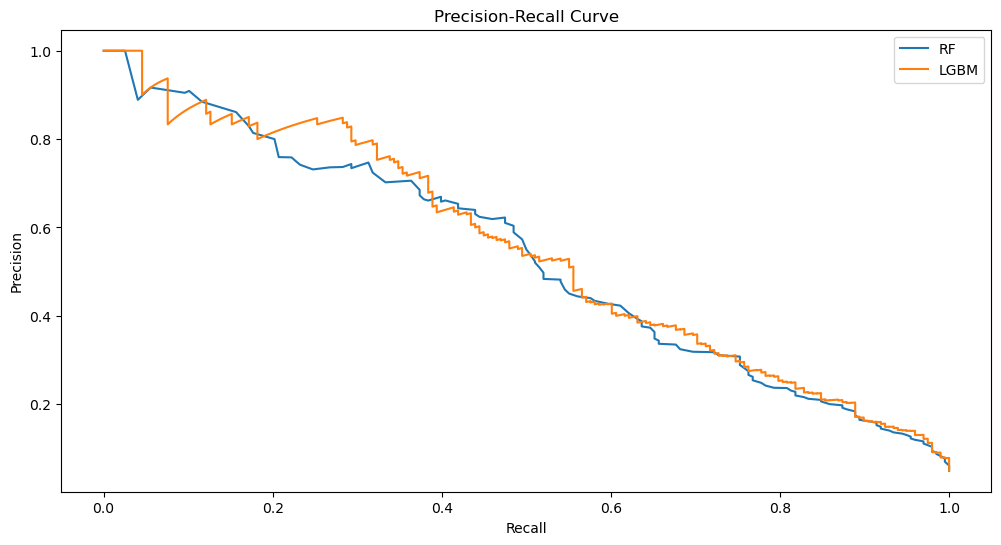

In [12]:
# 绘制精确率-召回率曲线
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_predictions)
precision_lgb, recall_lgb, _ = precision_recall_curve(y_test, lgb_predictions)

plt.figure(figsize=(12, 6))
plt.plot(recall_rf, precision_rf, label='RF')
plt.plot(recall_lgb, precision_lgb, label='LGBM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [13]:
# 生成分类报告
print("RF Classification Report\n")
print(classification_report(y_test, rf_model.predict(X_test_rf)))
print("\nLGBM Classification Report\n")
print(classification_report(y_test, lgb_model.predict(X_test_lgb)))

RF Classification Report

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      3802
           1       0.39      0.63      0.48       198

    accuracy                           0.93      4000
   macro avg       0.69      0.79      0.72      4000
weighted avg       0.95      0.93      0.94      4000


LGBM Classification Report

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      3802
           1       0.37      0.69      0.48       198

    accuracy                           0.93      4000
   macro avg       0.68      0.81      0.72      4000
weighted avg       0.95      0.93      0.94      4000


# 简单平均融合

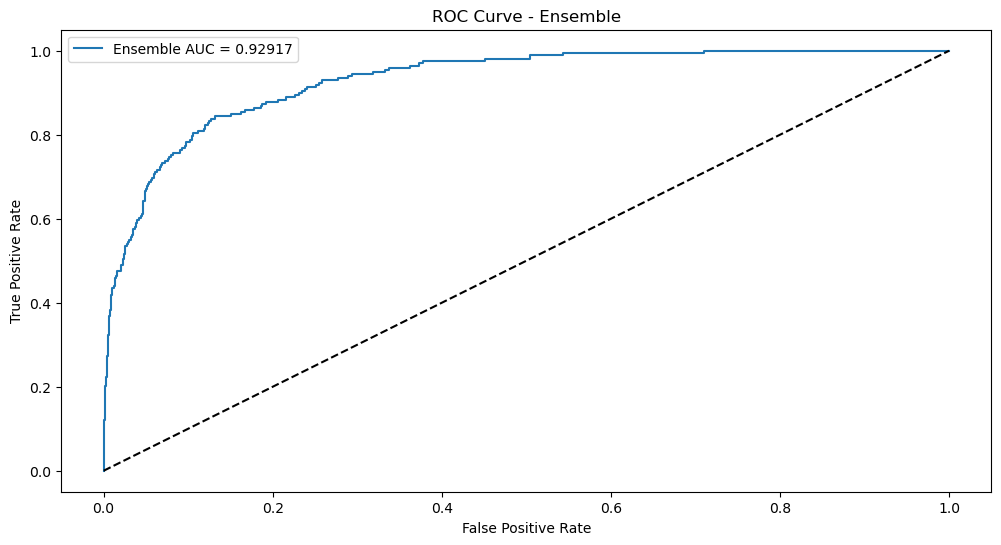

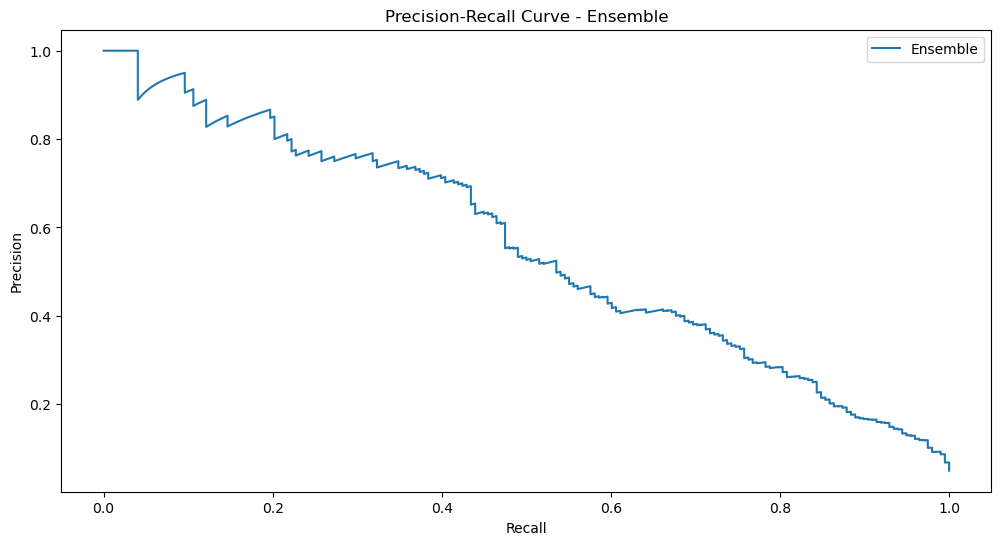

Ensemble Classification Report

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      3802
           1       0.40      0.68      0.51       198

    accuracy                           0.93      4000
   macro avg       0.69      0.81      0.74      4000
weighted avg       0.95      0.93      0.94      4000


In [14]:
# 进行简单平均融合
ensemble_probs = (rf_predictions + lgb_predictions) / 2

# 性能评估
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, ensemble_probs)
auc_ensemble = auc(fpr_ensemble, tpr_ensemble)

plt.figure(figsize=(12, 6))
plt.plot(fpr_ensemble, tpr_ensemble, label=f'Ensemble AUC = {auc_ensemble:.5f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble')
plt.legend()
plt.show()

precision_ensemble, recall_ensemble, _ = precision_recall_curve(y_test, ensemble_probs)

plt.figure(figsize=(12, 6))
plt.plot(recall_ensemble, precision_ensemble, label='Ensemble')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Ensemble')
plt.legend()
plt.show()

# 生成简单融合的分类报告（阈值需要自己设定，这里假设为0.5）
ensemble_predictions = np.where(ensemble_probs > 0.5, 1, 0)
print("Ensemble Classification Report\n")
print(classification_report(y_test, ensemble_predictions))

# 加权平均融合

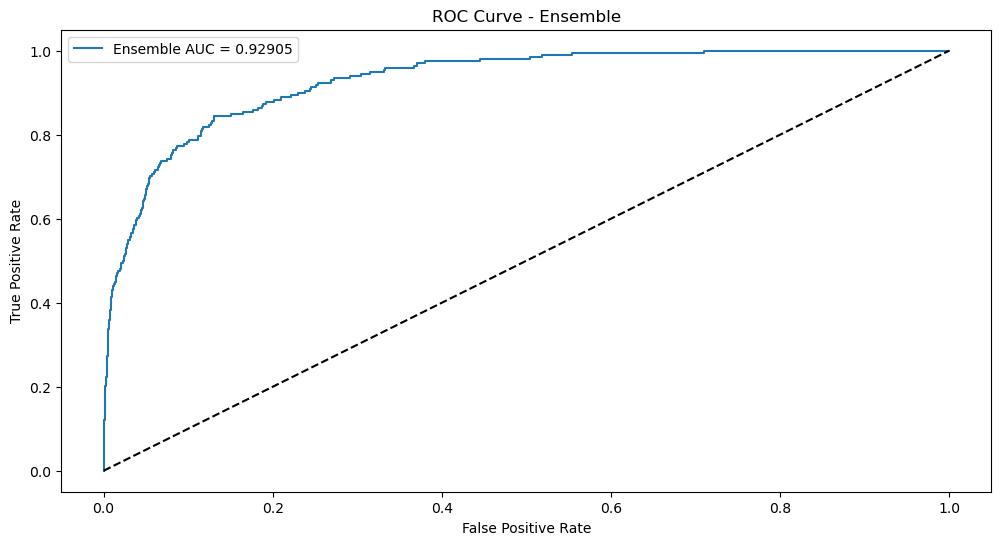

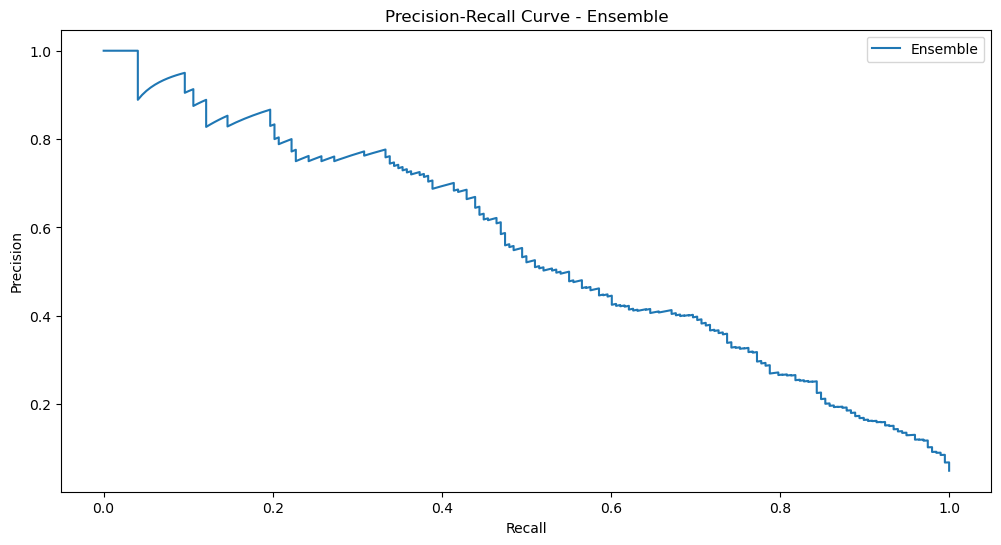

Ensemble Classification Report

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      3802
           1       0.40      0.67      0.50       198

    accuracy                           0.93      4000
   macro avg       0.69      0.81      0.73      4000
weighted avg       0.95      0.93      0.94      4000


In [15]:
# 进行加权融合
ensemble_probs = rf_predictions * 0.6 + lgb_predictions * 0.4

# 性能评估
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, ensemble_probs)
auc_ensemble = auc(fpr_ensemble, tpr_ensemble)

plt.figure(figsize=(12, 6))
plt.plot(fpr_ensemble, tpr_ensemble, label=f'Ensemble AUC = {auc_ensemble:.5f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble')
plt.legend()
plt.show()

precision_ensemble, recall_ensemble, _ = precision_recall_curve(y_test, ensemble_probs)

plt.figure(figsize=(12, 6))
plt.plot(recall_ensemble, precision_ensemble, label='Ensemble')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Ensemble')
plt.legend()
plt.show()

# 生成加权融合的分类报告
ensemble_predictions = np.where(ensemble_probs > 0.5, 1, 0)
print("Ensemble Classification Report\n")
print(classification_report(y_test, ensemble_predictions))


# 软投票

[LightGBM] [Info] Number of positive: 595, number of negative: 11405
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90786
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.049583 -> initscore=-2.953246
[LightGBM] [Info] Start training from score -2.953246


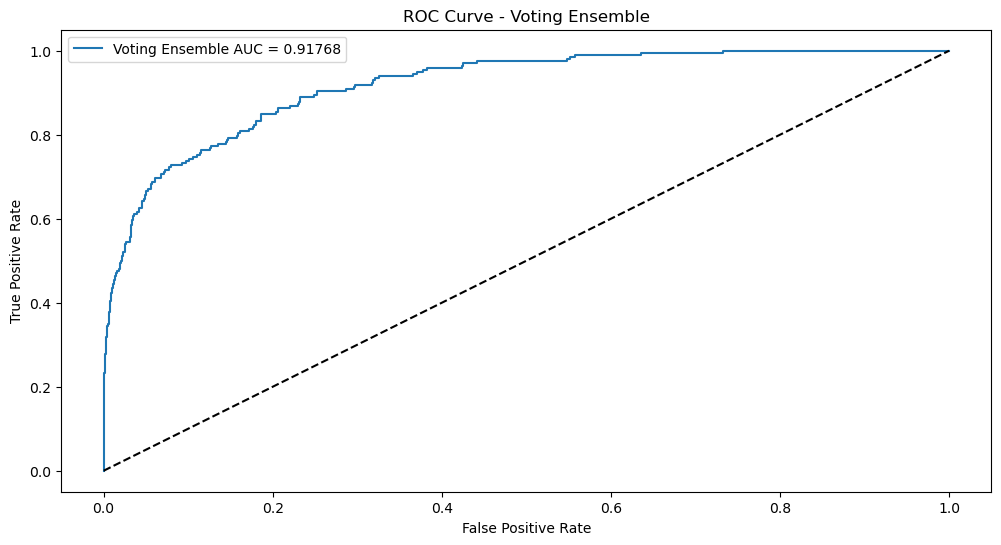

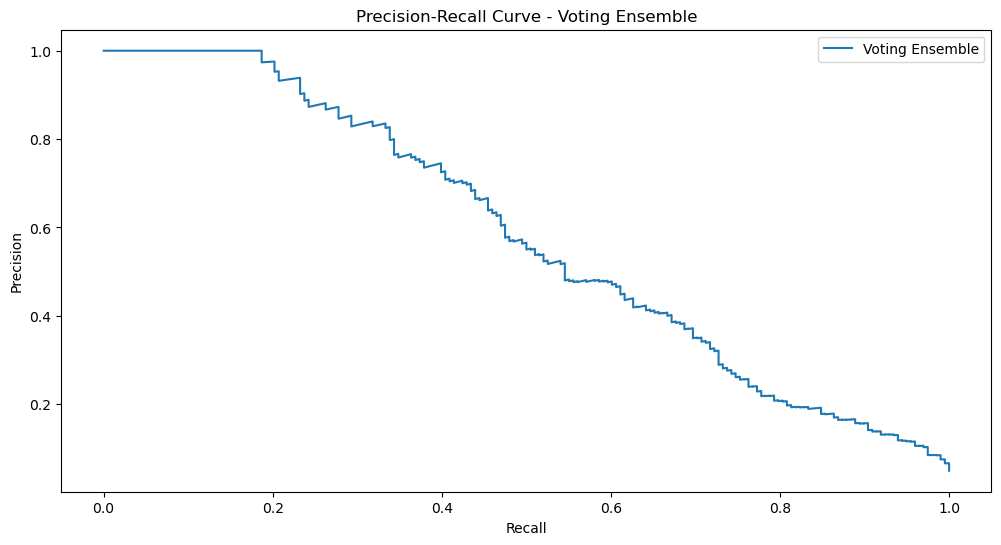

Voting Ensemble Classification Report

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3802
           1       0.77      0.36      0.49       198

    accuracy                           0.96      4000
   macro avg       0.87      0.68      0.74      4000
weighted avg       0.96      0.96      0.96      4000


In [16]:
from sklearn.ensemble import VotingClassifier

# 创建软投票融合模型
# 这里我们使用等权重，但您也可以根据模型的性能给予不同的权重
voting_clf = VotingClassifier(
    estimators=[('rf', rf_model), ('lgb', lgb_model)],
    voting='soft'
)

# 拟合模型（这里假设您已经有了训练集X_train, y_train）
voting_clf.fit(X_train, y_train)

# 进行预测
voting_predictions = voting_clf.predict_proba(X_test)[:, 1]

# 性能评估（ROC-AUC 曲线、精确率-召回率曲线、分类报告）
fpr_voting, tpr_voting, _ = roc_curve(y_test, voting_predictions)
auc_voting = auc(fpr_voting, tpr_voting)

plt.figure(figsize=(12, 6))
plt.plot(fpr_voting, tpr_voting, label=f'Voting Ensemble AUC = {auc_voting:.5f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Voting Ensemble')
plt.legend()
plt.show()

precision_voting, recall_voting, _ = precision_recall_curve(y_test, voting_predictions)

plt.figure(figsize=(12, 6))
plt.plot(recall_voting, precision_voting, label='Voting Ensemble')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Voting Ensemble')
plt.legend()
plt.show()

# 生成软投票融合的分类报告
voting_predictions_class = (voting_predictions > 0.5).astype(int)
print("Voting Ensemble Classification Report\n")
print(classification_report(y_test, voting_predictions_class))


# 硬投票

In [17]:
# 创建硬投票融合模型
voting_clf_hard = VotingClassifier(
    estimators=[('rf', rf_model), ('lgb', lgb_model)],
    voting='hard'
)

# 拟合模型
voting_clf_hard.fit(X_train, y_train)

# 进行预测
hard_voting_predictions = voting_clf_hard.predict(X_test)

# 性能评估
print("Hard Voting Ensemble Classification Report\n")
print(classification_report(y_test, hard_voting_predictions))


[LightGBM] [Info] Number of positive: 595, number of negative: 11405
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90786
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.049583 -> initscore=-2.953246
[LightGBM] [Info] Start training from score -2.953246
Hard Voting Ensemble Classification Report

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3802
           1       0.80      0.33      0.47       198

    accuracy                           0.96      4000
   macro avg       0.88      0.66      0.72      4000
weighted avg       0.96      0.96      0.96      4000


In [18]:
# 使用两个模型进行预测
rf_predictions_class = rf_model.predict(X_test_rf)
lgb_predictions_class = lgb_model.predict(X_test_lgb)

# 合并结果
combined_predictions = []

for rf_pred, lgb_pred in zip(rf_predictions_class, lgb_predictions_class):
    if rf_pred == 1 and lgb_pred == 1:
        combined_predictions.append(1)  # 两个模型都预测为1
    elif rf_pred == 0 and lgb_pred == 0:
        combined_predictions.append(0)  # 两个模型都预测为0
    else:
        combined_predictions.append(2)  # 预测结果不一致

# 转换为数组（如果需要）
combined_predictions = np.array(combined_predictions)


In [19]:
# 假设 rf_predictions_class 和 lgb_predictions_class 分别包含两个模型的预测类别
# 计算综合预测
combined_predictions = np.zeros_like(rf_predictions_class)
for i in range(len(rf_predictions_class)):
    if rf_predictions_class[i] == 1 and lgb_predictions_class[i] == 1:
        combined_predictions[i] = 1
    elif rf_predictions_class[i] == 0 and lgb_predictions_class[i] == 0:
        combined_predictions[i] = 0
    else:
        combined_predictions[i] = 2

# 输出原始类别与预测类别
for original, prediction in zip(y_test, combined_predictions):
    print(f'Original: {original}, Prediction: {prediction}')



Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 2
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 2
Original: 0, Prediction: 1
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 1, Prediction: 1
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 1
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 2
Original: 0, Prediction: 0
Original: 0, Prediction: 0
Original: 0, Prediction: 0
O

In [20]:
# 打印原始类别的计数
print("Original class counts:")
print(np.bincount(y_test))

# 打印预测类别的计数
print("Prediction class counts:")
print(np.bincount(combined_predictions))


Original class counts:
[3802  198]
Prediction class counts:
[3551  237  212]


# 简单计数投票

In [21]:
# 创建一个新的预测结果数组
combined_predictions = []

# 遍历两个模型的预测结果
for rf_pred, lgb_pred in zip(rf_predictions_class, lgb_predictions_class):
    # 如果两个模型中至少有一个预测为1，则最终预测为1，否则为0
    combined_pred = 1 if rf_pred == 1 or lgb_pred == 1 else 0
    combined_predictions.append(combined_pred)

# 将列表转换为NumPy数组
combined_predictions = np.array(combined_predictions)

# 输出分类报告
print(classification_report(y_test, combined_predictions))

unique, counts = np.unique(combined_predictions, return_counts=True)
print(dict(zip(unique, counts)))


              precision    recall  f1-score   support

           0       0.99      0.92      0.95      3802
           1       0.33      0.74      0.45       198

    accuracy                           0.91      4000
   macro avg       0.66      0.83      0.70      4000
weighted avg       0.95      0.91      0.93      4000

{0: 3551, 1: 449}


In [22]:
# 创建一个新的预测结果数组
combined_predictions = []

# 遍历两个模型的预测结果
for rf_pred, lgb_pred in zip(rf_predictions_class, lgb_predictions_class):
    # 如果两个模型都预测为1，则最终预测为1
    combined_pred = 1 if rf_pred == 1 and lgb_pred == 1 else 0
    combined_predictions.append(combined_pred)

# 将列表转换为NumPy数组
combined_predictions = np.array(combined_predictions)

# 输出分类报告
print(classification_report(y_test, combined_predictions))

unique, counts = np.unique(combined_predictions, return_counts=True)
print(dict(zip(unique, counts)))


              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3802
           1       0.48      0.58      0.52       198

    accuracy                           0.95      4000
   macro avg       0.73      0.77      0.75      4000
weighted avg       0.95      0.95      0.95      4000

{0: 3763, 1: 237}


# 多层感知机

In [31]:
from sklearn.metrics import roc_auc_score

# 根据特征列表选择数据
X_test_rf = X_test[rf_features]
X_test_lgb = X_test[lgb_features]
X_train_rf = X_train[rf_features]
X_train_lgb = X_train[lgb_features]

# 用于训练的特征可能是经过预处理的，根据模型训练时的需求
rf_predictions_train = rf_model.predict_proba(X_train_rf)[:, 1]
lgb_predictions_train = lgb_model.predict_proba(X_train_lgb)[:, 1]

# 测试集的预测
rf_predictions_test = rf_model.predict_proba(X_test_rf)[:, 1]
lgb_predictions_test = lgb_model.predict_proba(X_test_lgb)[:, 1]

# 创建堆叠特征集，用两个模型的概率作为特征
X_train_stacked = np.column_stack((rf_predictions_train, lgb_predictions_train))
X_test_stacked = np.column_stack((rf_predictions_test, lgb_predictions_test))

# 定义多层感知机分类器
mlp = MLPClassifier(hidden_layer_sizes=(100,50,30,10), activation='relu', solver='adam', random_state=42)

# 训练多层感知机
mlp.fit(X_train_stacked, y_train)

# 使用测试集进行预测
mlp_predictions = mlp.predict(X_test_stacked)
mlp_probabilities = mlp.predict_proba(X_test_stacked)[:, 1]

# 打印分类报告
print(classification_report(y_test, mlp_predictions))

# 计算AUC分数并打印
auc_score = roc_auc_score(y_test, mlp_probabilities)
print(f"AUC Score: {auc_score}")


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3802
           1       0.64      0.43      0.52       198

    accuracy                           0.96      4000
   macro avg       0.81      0.71      0.75      4000
weighted avg       0.95      0.96      0.96      4000


NameError: name 'roc_auc_score' is not defined